## Tensor RNN for long term forecasting demo 
- seq2seq architecture with tensor RNN cell
- variable length of forecasting horizon
- flexible temporal high order structure

### step 1: Flags for training configuration

In [1]:
"""Functions for downloading and reading time series data."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
from six.moves import xrange  # pylint: disable=redefined-builtin

from tensorflow.contrib.learn.python.learn.datasets import base
from tensorflow.python.framework import random_seed

import tensorflow as tf
from tensorflow.contrib import rnn
from reader import read_data_sets
from model_seq2seq import *
from trnn2 import *
import numpy
from train_config2 import *

import matplotlib.pyplot as plt
import seaborn as sns



flags = tf.flags

flags.DEFINE_string('f', '', 'kernel2')
flags.DEFINE_string("model", "LSTM", "Model used for learning.")
flags.DEFINE_string("data_path", "./data.npy", "Data input directory.")
flags.DEFINE_string("save_path", "./log/tlstm/", "Model output directory.")
flags.DEFINE_integer("inp_steps", 12, "burn in steps")
flags.DEFINE_integer("out_steps", 88, "test steps")
flags.DEFINE_integer("hidden_size", 2, "hidden layer size")
flags.DEFINE_float("learning_rate", 1e-3, "learning rate")
flags.DEFINE_float("decay_rate", 0.8, "decay rate")
flags.DEFINE_integer("virtual_dim", 1, "dimension of virtual legs")
flags.DEFINE_integer("num_orders", 8, "order of polynomials")
flags.DEFINE_integer("num_lags", 2, "time-lag length")
flags.DEFINE_integer("num_layers", 1, "time-lag length")
flags.DEFINE_integer("batch_size", 50, "batch size")

FLAGS = flags.FLAGS
print('Flags configuration loaded ...')




# Training Parameters
config = TrainConfig()
config.hidden_size = FLAGS.hidden_size
config.learning_rate = FLAGS.learning_rate
config.decay_rate = FLAGS.decay_rate
config.virtual_dim = FLAGS.virtual_dim
config.num_orders = FLAGS.num_orders
config.num_lags = FLAGS.num_lags
config.num_layers = FLAGS.num_layers
config.inp_steps = FLAGS.inp_steps
config.out_steps = FLAGS.out_steps
config.batch_size = FLAGS.batch_size


# Training Parameters
training_steps = config.training_steps
batch_size = config.batch_size
display_step = 500
inp_steps = config.inp_steps
out_steps = config.out_steps


# Read Dataset
dataset, stats = read_data_sets(FLAGS.data_path, True, inp_steps, out_steps)
num_input = stats['num_input']  # dataset data input (time series dimension: 1)
num_steps = stats['num_steps']


# Print training config
print('-'*120)
print('|input steps|', inp_steps,
      '|out steps|', out_steps,
      '|hidden size|', config.hidden_size,
      '|learning rate|', config.learning_rate,
      '|orders|', config.num_orders,
      '|virtual-D|', config.virtual_dim,
      '|time lag|', config.num_lags,
      '|layers|', config.num_layers
      )
print('-'*120)



Flags configuration loaded ...
loading time series ...
input type  <class 'numpy.ndarray'> (1000, 100, 1)
normalize to (0-1)
------------------------------------------------------------------------------------------------------------------------
|input steps| 12 |out steps| 88 |hidden size| 2 |learning rate| 0.001 |orders| 8 |virtual-D| 1 |time lag| 2 |layers| 1
------------------------------------------------------------------------------------------------------------------------


### Step 2: Build neural network models
Building seq2seq model for training/validation/testing,
validation and testing models are shared,
scheduled sampling is by default off 

In [2]:
# tf Graph input
X = tf.placeholder("float", [None, inp_steps, num_input])
Y = tf.placeholder("float", [None, out_steps, num_input])
Z = tf.placeholder("float", [None, out_steps, num_input])


# batch_x, batch_y, batch_z = dataset.train.next_batch(batch_size)
# X = tf.convert_to_tensor(batch_x, dtype=tf.float32)
# Y = tf.convert_to_tensor(batch_y, dtype=tf.float32)
# X = X[:, 0:5, :]
# Y = Y[:, 0:5, :]
# Z = Y

Model = globals()[FLAGS.model]


with tf.name_scope("Train"):
    with tf.variable_scope("TLSTM", reuse=False):
        train_pred = Model(X, Y, True,  config)
with tf.name_scope("Valid"):
    with tf.variable_scope("TLSTM", reuse=True):
        valid_pred = Model(X, Y, False,  config)
with tf.name_scope("Test"):
    with tf.variable_scope("TLSTM", reuse=True):
        test_pred = Model(X, Y, False,  config)
       


# Define loss and optimizer
train_loss = tf.sqrt(tf.reduce_mean(tf.squared_difference(train_pred, Z)))
valid_loss = tf.sqrt(tf.reduce_mean(tf.squared_difference(valid_pred, Z)))
test_loss = tf.sqrt(tf.reduce_mean(tf.squared_difference(test_pred, Z)))

# Exponential learning rate decay 
global_step = tf.Variable(0, trainable=False)
starter_learning_rate = config.learning_rate
learning_rate = tf.train.exponential_decay(starter_learning_rate, 
                                           global_step,
                                           2000, 
                                           config.decay_rate, 
                                           staircase=True)
optimizer = tf.train.RMSPropOptimizer(learning_rate)
train_op = optimizer.minimize(train_loss, global_step=global_step)

# # Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# Saver for the model and loss
saver = tf.train.Saver()
hist_loss =[]

print( str(Model) + 'Model built ...' )

<function LSTM at 0x181678a158>Model built ...


In [3]:
training_steps = 1000
with tf.Session() as sess:
    # Run the initializer
    sess.run(init)    
    
    for step in range(1, training_steps+1):
        batch_x, batch_y, batch_z = dataset.train.next_batch(batch_size)
        # Run optimization op (backprop)
        sess.run(train_op, 
                 feed_dict={X: batch_x, 
                            Y: batch_y, 
                            Z: batch_z}
                )
        if step % display_step == 0 or step == 1:
            # Calculate batch loss 
            tr_loss = sess.run(train_loss,
                               feed_dict={X: batch_x, 
                                          Y: batch_y, 
                                          Z:batch_z}
                              )
            run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
            print("Step " + str(step) + ", Minibatch Loss= " + "{:.4f}".format(tr_loss) )
            
            # Calculate validation
            valid_enc_inps = dataset.validation.enc_inps.reshape((-1, inp_steps, num_input))
            valid_dec_inps = dataset.validation.dec_inps.reshape((-1, out_steps, num_input))
            valid_dec_outs = dataset.validation.dec_outs.reshape((-1, out_steps, num_input))
            va_loss = sess.run(valid_loss,
                               feed_dict={X: valid_enc_inps,
                                          Y: valid_dec_inps, 
                                          Z: valid_dec_outs}
                              )
            print("Validation Loss:", va_loss)

    print("Optimization Finished!")

    # Calculate accuracy for test datasets
    test_enc_inps = dataset.test.enc_inps.reshape((-1, inp_steps, num_input))
    test_dec_inps = dataset.test.dec_inps.reshape((-1, out_steps, num_input))
    test_dec_outs = dataset.test.dec_outs.reshape((-1, out_steps, num_input))

    true, pred, loss = sess.run([Z, test_pred, test_loss],
                                feed_dict={X: test_enc_inps, 
                                           Y: test_dec_inps, 
                                           Z: test_dec_outs}
                               )
    print("Testing Loss:", loss)

    # Save the variables to disk.
    save_path = saver.save(sess, FLAGS.save_path)
    print("Model saved in file: %s" % save_path)
    # Save predictions 
    numpy.save(save_path+"predict.npy", (true, pred))
    # Save config file
    with open(save_path+"config.out", 'w') as f:
        f.write('hidden_size:'+ str(config.hidden_size)+'\n'+ 'learning_rate:'+ str(config.learning_rate)+ '\n')
        f.write('train_error:'+ str(loss) +'\n'+ 'valid_error:' + str(va_loss) + '\n'+ 'test_error:'+ str(loss) +'\n')

Step 1, Minibatch Loss= 0.4588
Validation Loss: 0.58466774
Step 500, Minibatch Loss= 0.0510
Validation Loss: 0.07850607
Step 1000, Minibatch Loss= 0.0267
Validation Loss: 0.03399983
Optimization Finished!
Testing Loss: 0.035456605
Model saved in file: ./log/tlstm/


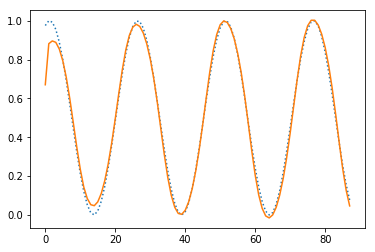

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

y_true = true
y_pred = pred
plt.plot(y_true[0,:,0].T,':')
plt.plot(y_pred[0,:,0].T,'-')